In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
import arviz as az

from collections import namedtuple

In [2]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 5]

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
    # point_estimate=None,
)


AttributeError: module 'pymc' has no attribute 'set_'

In [ ]:
data = pd.read_csv("data/cookie_cats.txt")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
data.groupby(["version"])["sum_gamerounds"].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


Text(0, 0.5, 'Retention Rate')

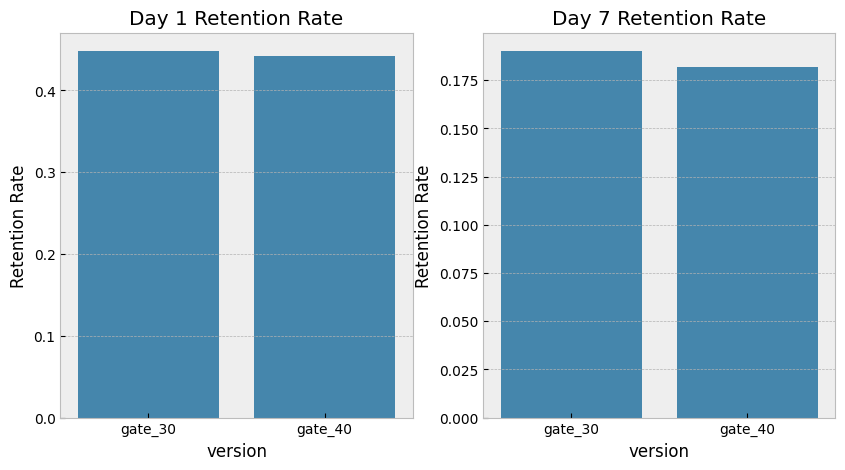

In [ ]:
retention_rates = (
    data.groupby("version")[["retention_1", "retention_7"]].mean().reset_index()
)

fig, ax = plt.subplots(1, 2)

sns.barplot(x="version", y="retention_1", data=retention_rates, ax=ax[0])
ax[0].set_title("Day 1 Retention Rate")
ax[0].set_ylabel("Retention Rate")

sns.barplot(x="version", y="retention_7", data=retention_rates, ax=ax[1])
ax[1].set_title("Day 7 Retention Rate")
ax[1].set_ylabel("Retention Rate")

<Axes: xlabel='version', ylabel='count'>

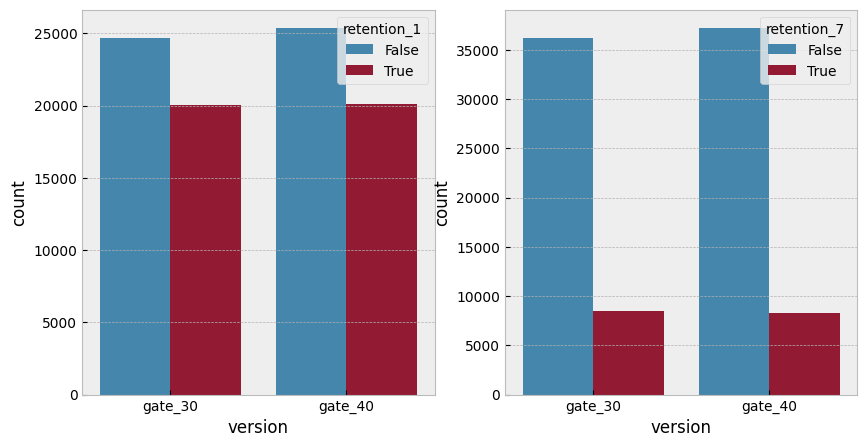

In [ ]:
plt.subplot(1, 2, 1)
sns.countplot(data=data, x="version", hue="retention_1")
plt.subplot(1, 2, 2)
sns.countplot(data=data, x="version", hue="retention_7")

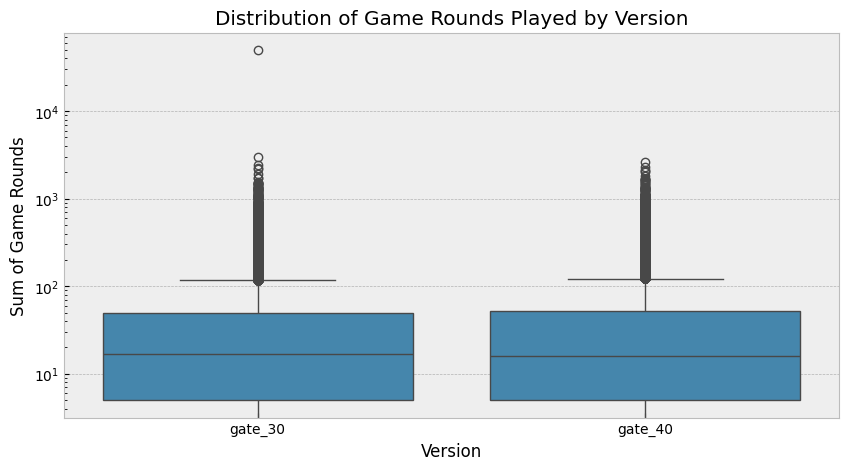

In [ ]:
sns.boxplot(x="version", y="sum_gamerounds", data=data)
plt.title("Distribution of Game Rounds Played by Version")
plt.xlabel("Version")
plt.ylabel("Sum of Game Rounds")
plt.yscale("log")
plt.show()

We seem to have some heavy outliers.


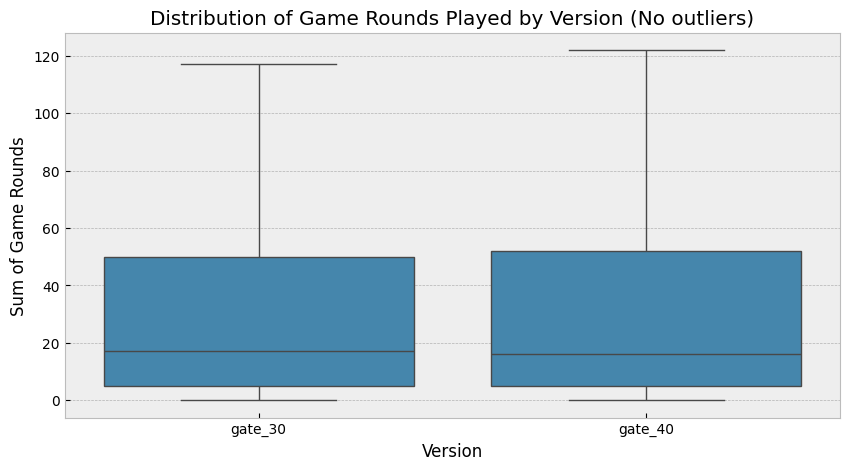

In [ ]:
sns.boxplot(x="version", y="sum_gamerounds", data=data, showfliers=False)
plt.title("Distribution of Game Rounds Played by Version (No outliers)")
plt.xlabel("Version")
plt.ylabel("Sum of Game Rounds")
# plt.yscale('log')
plt.show()

# Analysis

We first tackle the metrics of `retention_1` and `retention_2`. These can be modeled as *bernoulli conversions*, where the parameter of interest is the user performing an action. In this case, these actions are:

1. rention_1: Did the player come back and play 1 day after installing?
2. rention_7: Did the player come back and play 7 days after installing?

What we want to know is whether `gate_30` is "better" than `gate_40`. Let $\theta_{30}$ and $\theta_{40}$ be the true conversion rates for each version respectively. Then the outcome of whether a player converts (that is, come back to play 1 or 7 day after installing the game) is the random variable $Bernoulli(\theta_{30})$ and $Bernoulli(\theta_{40})$. And if we assume that the player's behaviors are independent of other players (a fair assumption), then the total conversions $y$ for a version has the Binomial distribution:
$$
y \sim  \sum^N Bernoulli(\theta) = Binomial(N, \theta)
$$

## Setting the Priors
Since we cannot know the true conversion rates, we model specify them using the *Beta distribution*. 

> Those familiar with Bayesian inference will notice why this is convenient. The Beta distribution is the conjugate prior of the Binomial, so we can get the posterior analytically. We will still use sampling using `PyMC` as this makes it easier to extend the model with different priors and assumptions.

Since we don't have any prior knowledge or the contet of the proble, we chose a non-informative prior $Beta(1, 1)$. $Beta(1, 1)$ is also known as the uniform distribution on the interval [0, 1]. Since conversion rates are probablities of players returning to the game, they must lie within [0, 1].


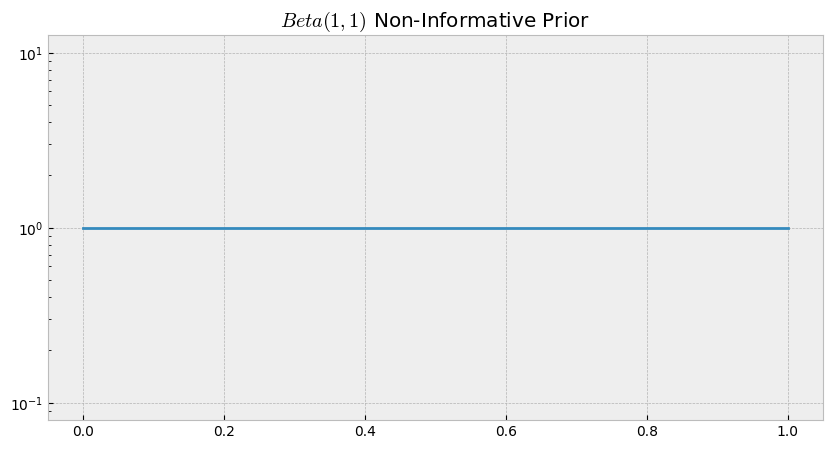

In [ ]:
plt.figure()
pz.Beta(alpha=1, beta=1).plot_pdf(legend=False)
plt.title("$Beta(1, 1)$ Non-Informative Prior")
plt.yscale("log")

### How do we chose priors?
A prior is what you believe *before you have any evidence*. There is usually no (loaded word alert) *objective* basis for choosing a prior. In practice, it depends on the broader context. Has the company run previous experiments? If so, we could use these to inform our priors. A weakly informative prior can be used when we have some information but want to the data to play a dominant role. That is, we provide a slight guidance without overwhelming the data. If on the other hand, we have substantial prior knowledge from past data or expert opinions, then we could provide a strongly informative prior. This will safe gaurd against false discoveries but may require more data to detect winning variants when they exist (also, more data = longer time required running the test).

### Emperical Bayes Method
> To be explored later

## Relative Uplift
Since we are interested in whether `gate_30` is better than `gate_40`, we use the relative uplift in conversion rates:
$$
\text{uplift}_{30} = \frac{\theta_{30}}{\theta_{40}} - 1 
$$

## Modeling


In [ ]:
BetaPrior = namedtuple("BetaPrior", ["alpha", "beta"])

def conversion_bernoulli_model(
    prior: BetaPrior, gate_30_data: np.array, gate_40_data: np.array
) -> pm.Model:
    with pm.Model() as model:
        p_30 = pm.Beta("p_30", alpha=prior.alpha, beta=prior.beta)
        p_40 = pm.Beta("p_40", alpha=prior.alpha, beta=prior.beta)

        obs_30 = pm.Bernoulli("obs_30", p=p_30, observed=gate_30_data)
        obs_40 = pm.Bernoulli("obs_40", p=p_40, observed=gate_40_data)

        uplift_40 = pm.Deterministic("uplift_40", p_40 / p_30 - 1)

        return model

In [ ]:
# separate the two versions into separate  vectors
# extract vectors for gate_30
retention_1_gate_30_a = (
    data.query("version == 'gate_30'")["retention_1"].astype(int).values
)

retention_7_gate_30_a = (
    data.query("version == 'gate_30'")["retention_7"].astype(int).values
)
#==================================================================

# extract vectors for gate_40
retention_1_gate_40_a = (
    data.query("version == 'gate_40'")["retention_1"].astype(int).values
)

retention_7_gate_40_a = (
    data.query("version == 'gate_40'")["retention_7"].astype(int).values
)

print(type((retention_1_gate_30_a)))

<class 'numpy.ndarray'>


### Retention 1


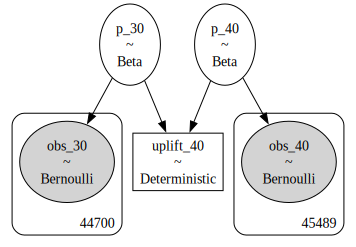

In [ ]:
prior = BetaPrior(alpha=1, beta=1)

model_1 = conversion_bernoulli_model(prior, retention_1_gate_30_a, retention_1_gate_40_a)
pm.model_to_graphviz(model_1, save="images/retention_model.png")

In [ ]:
with model_1:
    idata_1 = pm.sample(5000, nuts_sampler="numpyro")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_30, p_40]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


array([[<Axes: title={'center': 'p_30'}>,
        <Axes: title={'center': 'p_30'}>],
       [<Axes: title={'center': 'p_40'}>,
        <Axes: title={'center': 'p_40'}>],
       [<Axes: title={'center': 'uplift_40'}>,
        <Axes: title={'center': 'uplift_40'}>]], dtype=object)

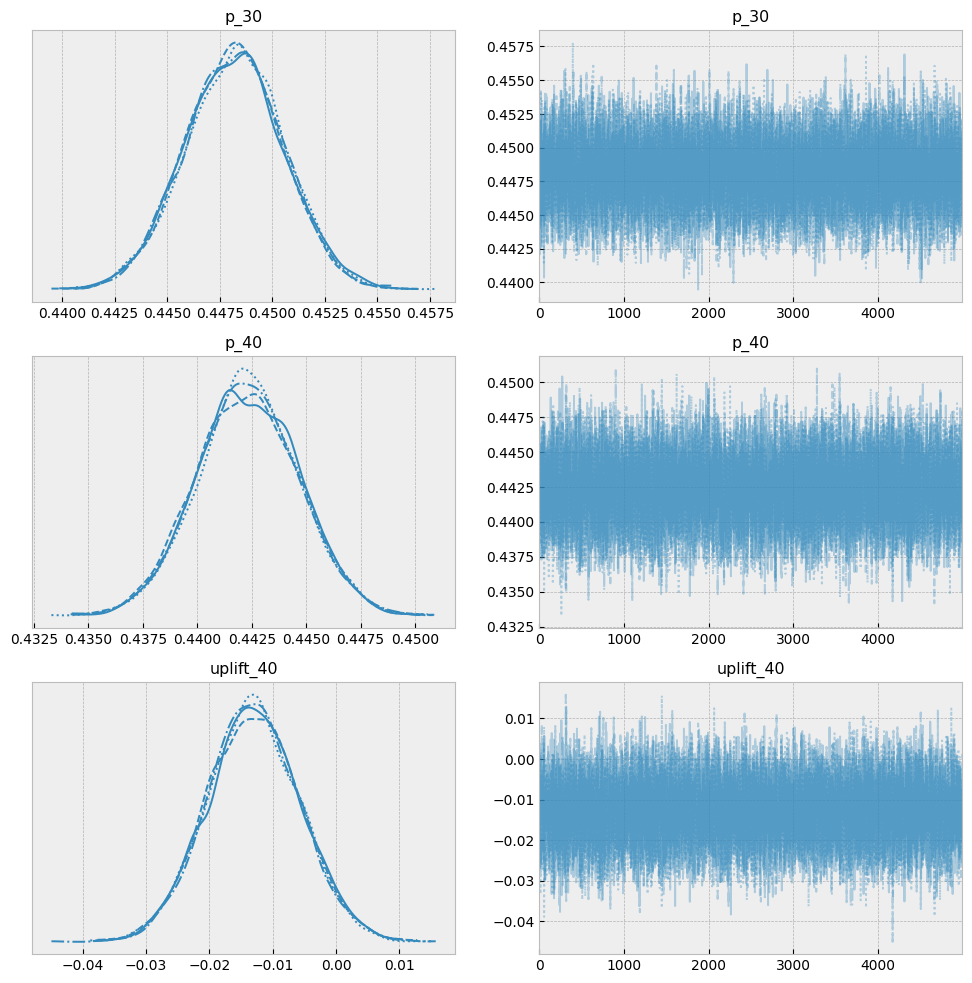

In [ ]:
az.plot_trace(idata_1, figsize=(6, 6))

<Axes: title={'center': 'uplift_40'}>

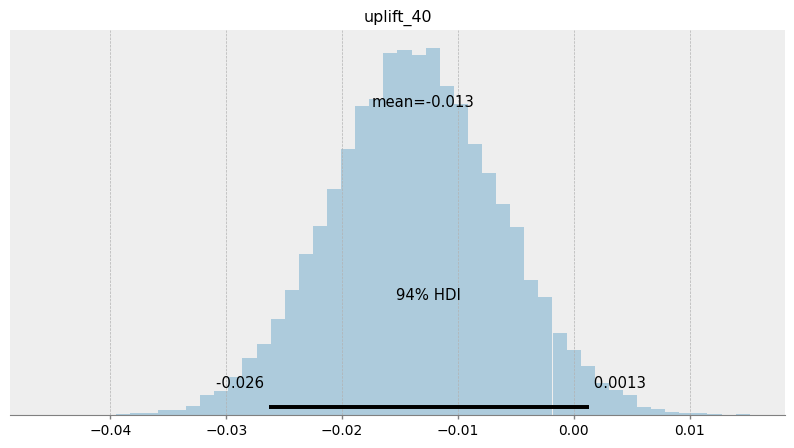

In [ ]:
az.plot_posterior(idata_1.posterior["uplift_40"], **plotting_defaults)

### Binomial Model

In [ ]:
BinomialData = namedtuple("BinomialData", ["trials", "successes"])

binomial_data = (
    data[["version", "retention_1", "retention_7"]]
    .groupby("version")
    .agg(["count", "sum"])
    .rename(columns={"count": "trials", "sum": "successes"})
    # .transpose()
)
print(binomial_data)

retention_1_gate_30_trials = binomial_data["retention_1"].loc["gate_30"]["trials"]
retention_1_gate_30_successes = binomial_data["retention_1"].loc["gate_30"]["successes"]

retention_1_gate_40_trials = binomial_data["retention_1"].loc["gate_40"]["trials"]
retention_1_gate_40_successes = binomial_data["retention_1"].loc["gate_40"]["successes"]

data_30_1 = BinomialData(
    trials=retention_1_gate_30_trials, successes=retention_1_gate_30_successes
)

data_40_1 = BinomialData(
    trials=retention_1_gate_40_trials, successes=retention_1_gate_40_successes
)

print(data_30_1)
print(data_40_1)

        retention_1           retention_7          
             trials successes      trials successes
version                                            
gate_30       44700     20034       44700      8502
gate_40       45489     20119       45489      8279
BinomialData(trials=44700, successes=20034)
BinomialData(trials=45489, successes=20119)


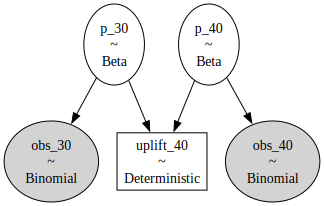

In [ ]:
def conversion_binomial_model(
    prior: BetaPrior, gate_30_data: np.array, gate_40_data: np.array
) -> pm.Model:
    with pm.Model() as model:
        p_30 = pm.Beta("p_30", alpha=prior.alpha, beta=prior.beta)
        p_40 = pm.Beta("p_40", alpha=prior.alpha, beta=prior.beta)

        obs_30 = pm.Binomial("obs_30", p=p_30, n=data_30_1.trials, observed=data_30_1.successes)
        obs_40 = pm.Binomial("obs_40", p=p_40, n=data_40_1.trials, observed=data_40_1.successes)

        uplift_40 = pm.Deterministic("uplift_40", p_40 / p_30 - 1)

        return model
    
model_binomial = conversion_binomial_model(prior, data_30_1, data_40_1)

pm.model_to_graphviz(model_binomial)

In [ ]:
with model_binomial:
    idata_1_1 = pm.sample(5000, nuts_sampler="numpyro")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_30, p_40]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


array([[<Axes: title={'center': 'p_30'}>,
        <Axes: title={'center': 'p_30'}>],
       [<Axes: title={'center': 'p_40'}>,
        <Axes: title={'center': 'p_40'}>],
       [<Axes: title={'center': 'uplift_40'}>,
        <Axes: title={'center': 'uplift_40'}>]], dtype=object)

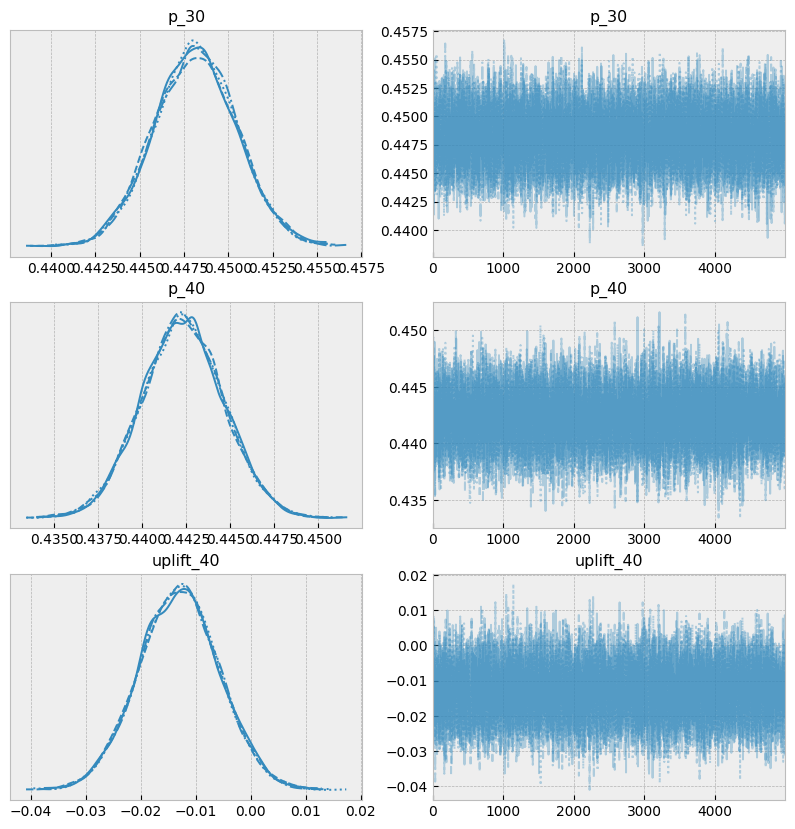

In [ ]:
az.plot_trace(idata_1_1, figsize=(10,10))

<Axes: title={'center': 'uplift_40'}>

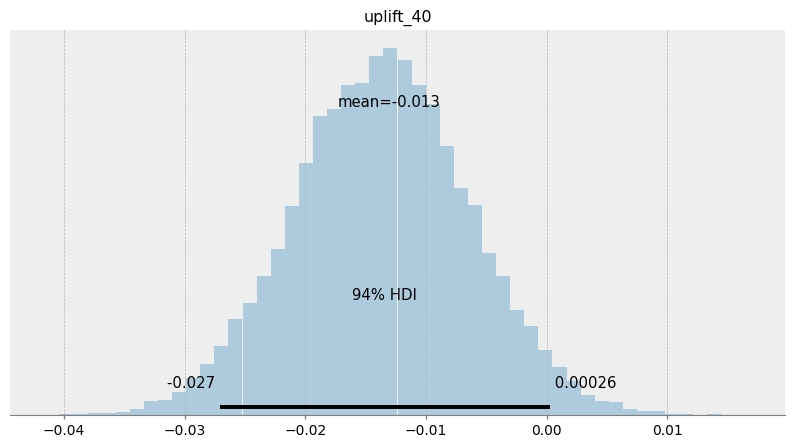

In [ ]:
az.plot_posterior(idata_1_1.posterior["uplift_40"], **plotting_defaults)

### Retention 7

In [ ]:
model_7 = conversion_bernoulli_model(prior, retention_7_gate_30_a, retention_7_gate_40_a)
pm.model_to_graphviz(model_7)

with model_7:
    idata_7 = pm.sample(5000, nuts_sampler="numpyro")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_30, p_40]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 33 seconds.


array([[<Axes: title={'center': 'p_30'}>,
        <Axes: title={'center': 'p_30'}>],
       [<Axes: title={'center': 'p_40'}>,
        <Axes: title={'center': 'p_40'}>],
       [<Axes: title={'center': 'uplift_40'}>,
        <Axes: title={'center': 'uplift_40'}>]], dtype=object)

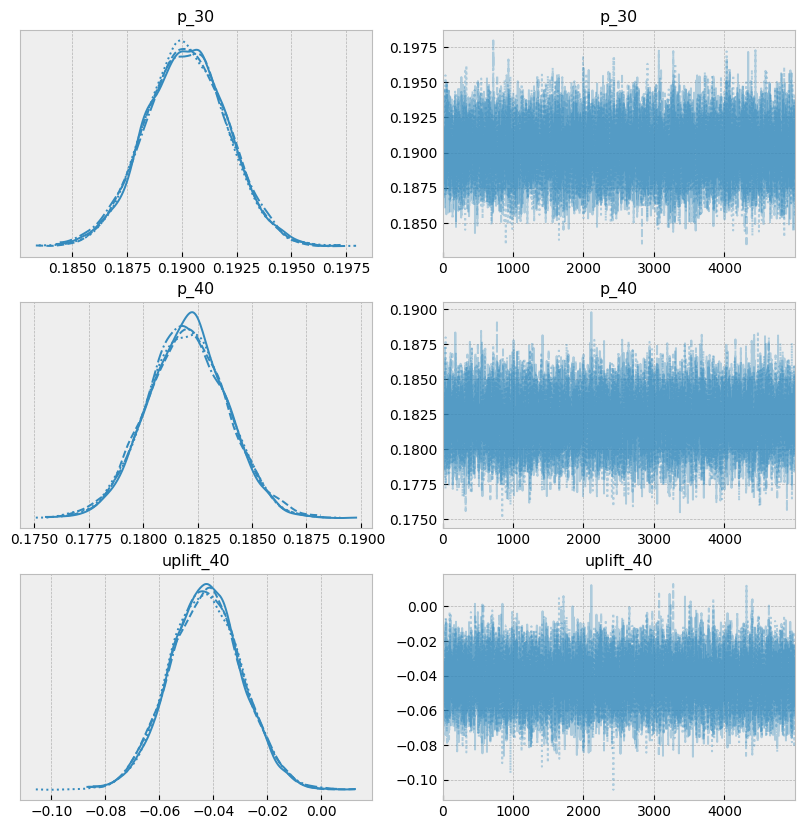

In [ ]:
az.plot_trace(idata_7, figsize=(10, 10))

<Axes: title={'center': 'uplift_40'}>

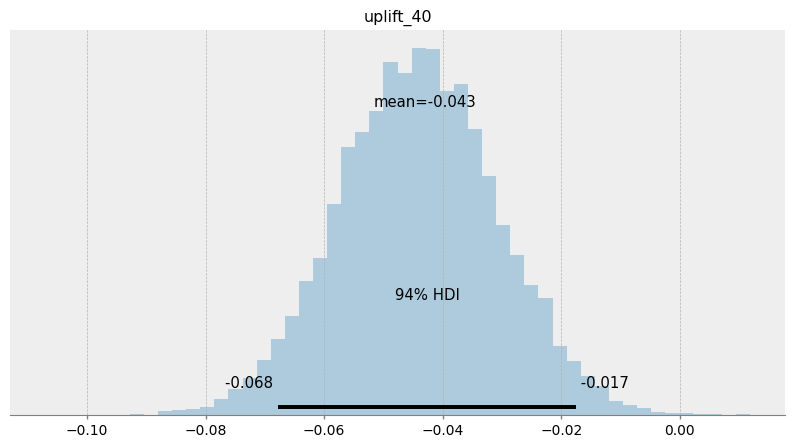

In [ ]:
az.plot_posterior(idata_7.posterior["uplift_40"], **plotting_defaults)

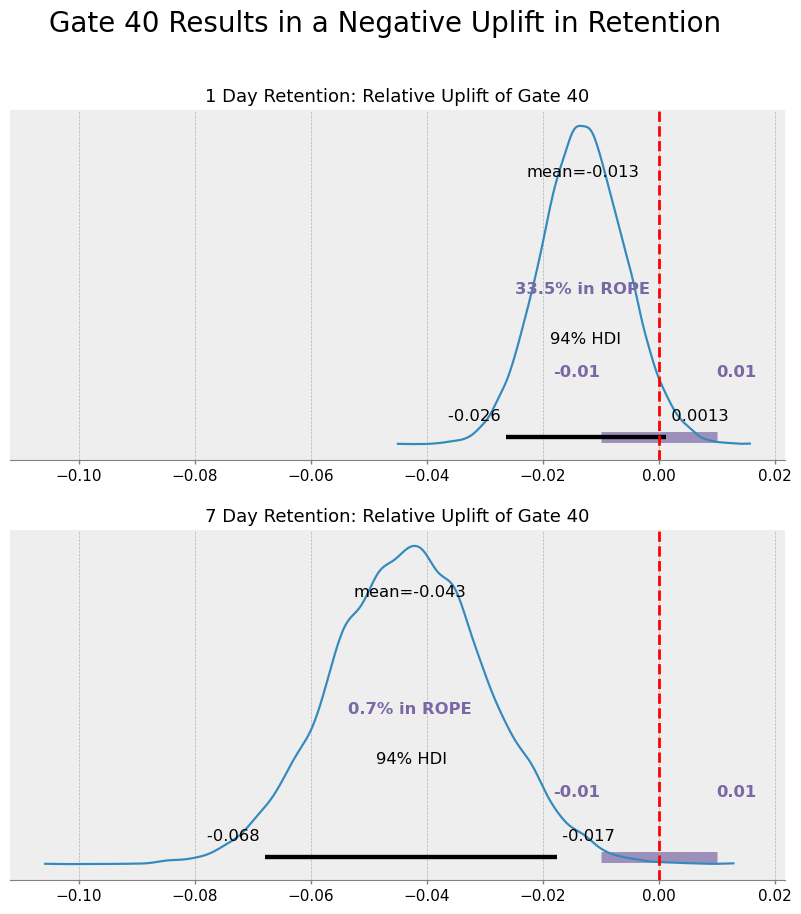

In [ ]:


fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
fig.suptitle("Gate 40 Results in a Negative Uplift in Retention", fontsize=20)

mean_uplift_40 = idata_1.posterior["uplift_40"].mean().item()
az.plot_posterior(
    idata_1.posterior["uplift_40"], ax=axes[0], rope=[-0.01, 0.01], textsize=11,
)
axes[0].set_title("1 Day Retention: Relative Uplift of Gate 40", fontsize=13)
axes[0].axvline(x=0, color="red", linestyle="--")

az.plot_posterior(
    idata_7.posterior["uplift_40"], ax=axes[1], rope=[-0.01, 0.01], textsize=11,
)
axes[1].set_title("7 Day Retention: Relative Uplift of Gate 40", fontsize=13,)
axes[1].axvline(x=0, color="red", linestyle="--")
plt.savefig("images/retention_uplift.png")

In [ ]:
mean_uplift_40 = idata_1.posterior["uplift_40"].mean().item()
print(mean_uplift_40)

-0.013047583133402213


# Summary

In [ ]:
from pprint import pprint
pprint("Retention_1: Realtive Uplift for Gate 40")
pprint(az.summary(idata_1, kind='stats'))
pprint("============================================================")
pprint("Retention_7: Realtive Uplift for Gate 40")
print(az.summary(idata_7, kind='stats'))

'Retention_1: Realtive Uplift for Gate 40'
            mean     sd  hdi_3%  hdi_97%
p_30       0.448  0.002   0.444    0.453
p_40       0.442  0.002   0.438    0.447
uplift_40 -0.013  0.007  -0.026    0.001
'============================================================'
'Retention_7: Realtive Uplift for Gate 40'
            mean     sd  hdi_3%  hdi_97%
p_30       0.190  0.002   0.187    0.194
p_40       0.182  0.002   0.179    0.185
uplift_40 -0.043  0.013  -0.068   -0.017


## Insights from the Analysis
1. Retention_1 (1-Day Retention):
	- **p_30 (Gate 30)**: The mean retention rate is 0.448 (44.8%).
	- **p_40 (Gate 40)**: The mean retention rate is 0.442 (44.2%).
	- **Uplift (Gate 40 vs. Gate 30)**: The mean uplift is 0.013 (1.3%) with a high density interval (HDI) from -0.001 to 0.028. The interval includes zero, indicating that there might be no significant difference between the two versions.
2. Retention_7 (7-Day Retention):
	- **p_30 (Gate 30)**: The mean retention rate is 0.190 (19.0%).
	- **p_40 (Gate 40)**: The mean retention rate is 0.182 (18.2%).
	- **Uplift (Gate 40 vs. Gate 30)**: The mean uplift is 0.045 (4.5%) with a HDI from 0.019 to 0.073. The interval does not include zero, indicating that Gate 30 has a statistically significant higher retention rate over 7 days compared to Gate 40.